In [1]:
import cv2
print("the version of opencv used is : " + cv2.__version__)

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random

the version of opencv used is : 4.1.2


# step 1. Load data

In [38]:
masks_path = glob.glob('dataset/real_hand/*.npy')
images_path = glob.glob('dataset/real_hand/*rgb.jpg')

background_image_path = glob.glob('../video_images/*.jpg')

In [3]:
def find_mask_and_image(i):
    hand_mask = np.load("dataset/real_hand/"+str(i)+"_mask.npy")
    image = cv2.imread("dataset/real_hand/"+str(i)+"_rgb.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return True, image, hand_mask

def find_largest_contour(contours):
    max_id = -1
    count_num = -1
    for i in range(len(contours)):
        count_t = contours[i].size
        if(count_t > count_num):
            count_num = count_t
            max_id = i
    return max_id

def average_points(points):
    summary_x = 0
    summary_y = 0
    length = len(points)
    for i in range(length):
        summary_x = summary_x + points[i][0]
        summary_y = summary_y + points[i][1]
    summary_x = summary_x / length
    summary_y = summary_y / length
    return tuple([int(summary_x), int(summary_y)])

In [4]:
def showImages(i):
    ret, image, mask = find_mask_and_image(i)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.grid()
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(mask)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_id = find_largest_contour(contours)

    cnt = contours[max_id]
    hull = cv2.convexHull(cnt,returnPoints = False)
    defects = cv2.convexityDefects(cnt,hull)

    pts_inbetween = []
    far_points = []
    finger_points = []
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(cnt[s][0])
        end = tuple(cnt[e][0])
        far = tuple(cnt[f][0])
        cv2.line(image,start,end,[0,255,0],2)
        if(d > 800):
            cv2.circle(image,far,15,[0,0,255],-1)
            far_points.append(far)
            if(len(pts_inbetween) > 0):
                finger_point = average_points(pts_inbetween)
                finger_points.append(finger_point)
                cv2.circle(image,finger_point,15,[255,0,255],-1)
                pts_inbetween = []
        else:
            pts_inbetween.append(start)

    cv2.drawContours(image,contours[max_id],-1,(0,255,0),2)
    
    plt.subplot(133)
    plt.imshow(image)

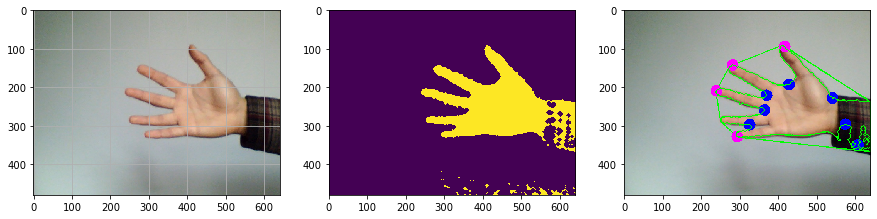

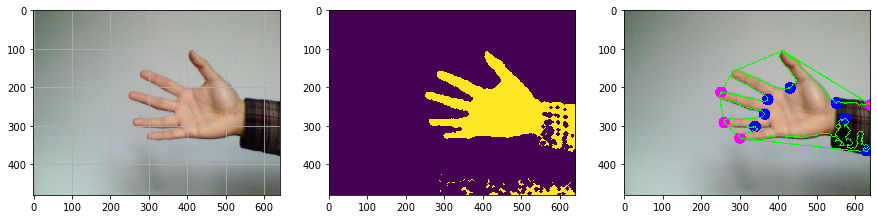

In [34]:
i = 10
showImages(i)
showImages(i+1)

# step 2. Label the images

In [6]:
def find_path_index(path):
    int_str = path[18:].split("_")[0]
    return int(int_str)

def find_path_index_i(i):
    path = images_path[i]
    int_str = path[18:].split("_")[0]
    return int(int_str)

In [7]:
def draw_label(labels, i):
    ret, image, mask = find_mask_and_image(i)
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.grid()
    plt.imshow(image)
    
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),10,[255,0,255],-1)
    
    for i in range(5):
        idx_x = 2*i + 1
        idx_y = 2*i
        start = tuple([labels[11], labels[10]])
        end = tuple([labels[idx_x], labels[idx_y]])
        if(labels[idx_x] > 0):
            cv2.line(image,start,end,[0,255,0],2)
    
    plt.subplot(122)
    plt.imshow(image)
    
def draw_label_show(labels, image): 
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),10,[255,0,255],-1)
    
    for i in range(5):
        idx_x = 2*i + 1
        idx_y = 2*i
        start = tuple([labels[11], labels[10]])
        end = tuple([labels[idx_x], labels[idx_y]])
        if(labels[idx_x] > 0):
            cv2.line(image,start,end,[0,255,0],2)
    return image

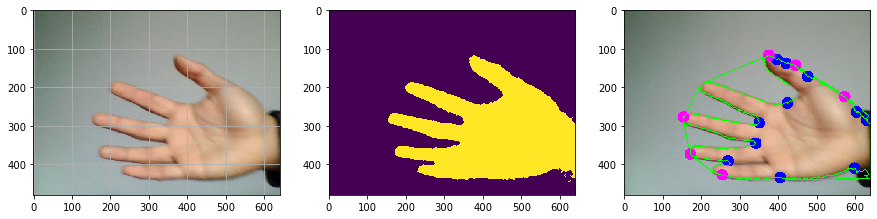

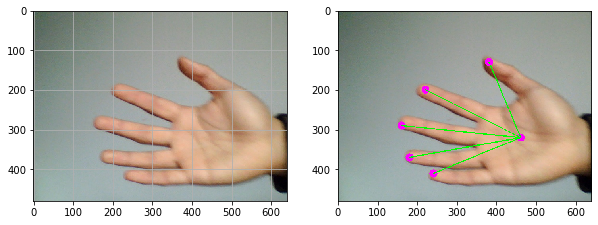

In [9]:
i = 3
showImages(i)
label_t = [130,380, 200,220, 290,160, 370,180, 410,240, 320,460]

draw_label(label_t, i)
np.save("dataset/real_hand/"+str(i)+"_label.npy", label_t)

In [74]:
i = 104
ret, image, mask = find_mask_and_image(i)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

count = 0
label_test = [-1,-1, -1,-1, -1,-1, -1,-1, -1,-1, -1,-1]
def draw_circle(event,x,y,flags,param):
    global count, label_test,i
    if event==cv2.EVENT_LBUTTONDOWN:
        if(count < 6):
            cv2.circle(image,(x,y),10,(255,0,255),-1)
            label_test[2*count] = y
            label_test[2*count+1] = x
            count = count + 1
        if(count == 6):
            draw_label_show(label_test, image)
            np.save("dataset/real_hand/"+str(i)+"_label.npy", label_test)
    elif event == cv2.EVENT_RBUTTONDOWN:
        count = count + 1

cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_circle)
 
while(1):
    cv2.imshow('image',image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [77]:
for path in images_path:
    i = find_path_index(path)
    
    ret, image, mask = find_mask_and_image(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    count = 0
    label_test = [-1,-1, -1,-1, -1,-1, -1,-1, -1,-1, -1,-1]

    def draw_circle(event,x,y,flags,param):
        global count, label_test,i
        if event==cv2.EVENT_LBUTTONDOWN:
            if(count < 6):
                cv2.circle(image,(x,y),10,(255,0,255),-1)
                label_test[2*count] = y
                label_test[2*count+1] = x
                count = count + 1
            if(count == 6):
                draw_label_show(label_test, image)
                np.save("dataset/real_hand/"+str(i)+"_label.npy", label_test)
        elif event == cv2.EVENT_RBUTTONDOWN:
            count = count + 1
    
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',draw_circle)
 
    while(1):
        cv2.imshow('image',image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
cv2.destroyAllWindows()

# step 3. Make Train Images

In [8]:
out_image_size = [480,640]
def make_back_ground_image(j, left_top_ratio, resize_ratio_seed):    
    back = cv2.imread(background_image_path[j])
    back = cv2.cvtColor(back, cv2.COLOR_BGR2RGB)
    
    resize_ratio = max(out_image_size[0]/ back.shape[0], out_image_size[1]/ back.shape[1])
    resize_ratio = resize_ratio / resize_ratio_seed
    
    back = cv2.resize(back, (0, 0), fx=resize_ratio, fy=resize_ratio, interpolation=cv2.INTER_NEAREST)
 
    left_top = [0,0]
    left_top[0] = int((back.shape[0]-out_image_size[0])*left_top_ratio[0])
    left_top[1] = int((back.shape[1]-out_image_size[1])*left_top_ratio[1])
    
    #if(left_top[0] < 0):
    #    left_top[0] = 0
    #if(left_top[1] < 0):
    #    left_top[1] = 0
    #if(left_top[0] + out_image_size[0] >= back.shape[0]):
    #    left_top[0] = back.shape[0] - out_image_size[0] - 1
    #if(left_top[1] + out_image_size[1] >= back.shape[1]):
    #    left_top[1] = back.shape[1] - out_image_size[1] - 1
    
    back_new = back[left_top[0]:left_top[0]+out_image_size[0],left_top[1]:left_top[1]+out_image_size[1], : ]
    return back_new

In [9]:
def rotate_label(labels, image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    labels_out = labels
    for i in range(6):
        idx_x = labels[2*i + 1]
        idx_y = labels[2*i]
        if(idx_x > 0):
            labels_out[2*i+1] = M[0, 0] * idx_x + M[0, 1] * idx_y + M[0, 2]
            labels_out[2*i] = M[1, 0] * idx_x + M[1, 1] * idx_y + M[1, 2]

    # perform the actual rotation and return the image
    return labels_out

def label_resize(labels, ratio_x, ratio_y):
    labels_out = labels
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            labels_out[2*i + 1] = labels[idx_x] * ratio_x
            labels_out[2*i] = labels[idx_y] * ratio_y
    return labels_out

def label_shift(labels, shift):
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            labels[idx_x] = labels[idx_x] + shift[1]
            labels[idx_y] = labels[idx_y] + shift[0]
    return labels

def make_int(labels):
    label_out = labels
    for i in range(12):
        label_out[i] = int(labels[i])
    return label_out
        
        
def draw_label_image(image, labels):
    labels = make_int(labels)
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),10,[255,0,255],-1)
    
    for i in range(5):
        idx_x = 2*i + 1
        idx_y = 2*i
        start = tuple([labels[11], labels[10]])
        end = tuple([labels[idx_x], labels[idx_y]])
        if(labels[idx_x] > 0):
            cv2.line(image,start,end,[0,255,0],2)
    return image

In [47]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def make_hand_image(i, label, rotate, left_top_ratio, resize_ratio):
    mask_image = np.zeros((out_image_size[0],out_image_size[1]),  dtype=np.uint8)
    hand_image = np.zeros((out_image_size[0],out_image_size[1],3),  dtype=np.uint8)
    
    ret, image, mask = find_mask_and_image(i)
    label = rotate_label(label, image, rotate)
    mask = rotate_bound(mask, rotate)
    image = rotate_bound(image, rotate)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.erode(mask,kernel,iterations=4)
    mask = cv2.dilate(mask,kernel,iterations=4)
    
    label = label_resize(label, resize_ratio, resize_ratio)
    mask = cv2.resize(mask, (0, 0), fx=resize_ratio, fy=resize_ratio)
    image = cv2.resize(image, (0, 0), fx=resize_ratio, fy=resize_ratio)
    #hand_mask = cv2.bitwise_and(image,image,mask=mask)
    
    left_top = [0,0]
    left_top[0] = max(int((mask_image.shape[0]-mask.shape[0])*left_top_ratio[0]),0)
    left_top[1] = max(int((mask_image.shape[1]-mask.shape[1])*left_top_ratio[1]),0)
    
    right_down_x = min(left_top[0]+mask.shape[0], out_image_size[0])
    right_down_y = min(left_top[1]+mask.shape[1], out_image_size[1])
    
    mask_image[left_top[0]:right_down_x,left_top[1]:right_down_y] = mask[0:right_down_x-left_top[0], 0:right_down_y-left_top[1]]
    hand_image[left_top[0]:right_down_x,left_top[1]:right_down_y] = image[0:right_down_x-left_top[0], 0:right_down_y-left_top[1]]
    #mask_image = rotate_bound(mask_image, rotate)
    mask_image[mask_image>0] = 255
    
    label = label_shift(label, [left_top[0], left_top[1]])
    return mask_image, hand_image, label

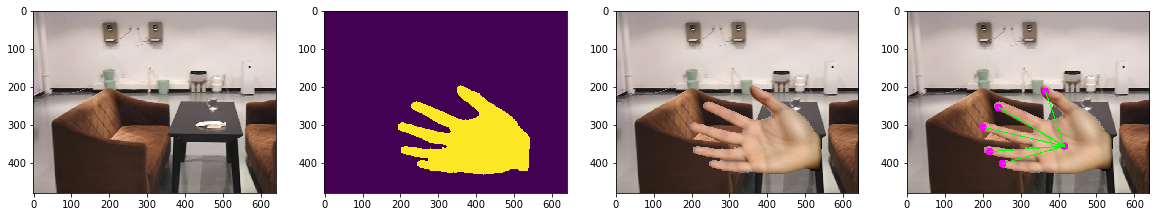

In [48]:
i = 3
j = 15

#idx_i = find_path_index(masks_path[i])
#print("show images of index : " ,idx_i, ". and background : ", j, ".")
label_i = np.load("dataset/real_hand/"+str(i)+"_label.npy")

#label_10 = [100,410, 150,290, 205,250, 280,260, 320,300, 250,450]
#label_i = label_10

bleft_top_seed_x = random.random()
bleft_top_seed_y = random.random()
bratio_seed = random.uniform(0.4, 1)

back = make_back_ground_image(j, [bleft_top_seed_x,bleft_top_seed_y],bratio_seed)

hleft_top_seed_x = random.random()
hleft_top_seed_y = random.random()
hratio_seed = random.uniform(0.4, 1)
hrotate = random.uniform(0, 90)

hand, image_hand, label_i = make_hand_image(i, label_i, hrotate, [hleft_top_seed_x,hleft_top_seed_y] ,hratio_seed)

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(back)
plt.subplot(142)
plt.imshow(hand)

inv_hand = hand
cv2.bitwise_not(inv_hand, hand);
back = cv2.bitwise_and(back, back, mask=inv_hand)

cv2.bitwise_not(inv_hand, inv_hand);
hand = cv2.bitwise_and(image_hand, image_hand, mask=hand)

mixed = cv2.add(back, hand)

plt.subplot(143)
plt.imshow(mixed)

draw_label_image(mixed, label_i)
plt.subplot(144)
plt.imshow(mixed)

In [46]:
def make_data(i_t,j, path, num_back, num_hand):
    label_i = np.load("dataset/real_hand/"+str(i_t)+"_label.npy")
    count_t = 0
    
    for n_back in range(num_back):
        bleft_top_seed_x = random.random()
        bleft_top_seed_y = random.random()
        bratio_seed = random.uniform(0.4, 1)

        back_ori = make_back_ground_image(j, [bleft_top_seed_x,bleft_top_seed_y],bratio_seed)

        for n_hand in range(num_hand):
            hleft_top_seed_x = random.random()
            hleft_top_seed_y = random.random()
            hratio_seed = random.uniform(0.4, 1)
            hrotate = random.uniform(0, 90)

            label_changed = np.load("dataset/real_hand/"+str(i_t)+"_label.npy")
            hand, image_hand, label_changed = make_hand_image(i_t, label_changed, hrotate, [hleft_top_seed_x,hleft_top_seed_y] ,hratio_seed)

            back = back_ori
            inv_hand = hand
            cv2.bitwise_not(inv_hand, hand);
            back = cv2.bitwise_and(back, back, mask=inv_hand)

            cv2.bitwise_not(inv_hand, inv_hand);
            hand = cv2.bitwise_and(image_hand, image_hand, mask=hand)

            mixed = cv2.add(back, hand)
            mixed = cv2.cvtColor(mixed, cv2.COLOR_BGR2RGB)
            cv2.imwrite(path+str(i_t)+"_"+str(j)+"_"+str(count_t)+"_rgb.jpg", mixed)
            np.save(path+str(i_t)+"_"+str(j)+"_"+str(count_t)+"_mask.npy", label_changed)
            
            draw_label_image(mixed, label_changed)
            cv2.imwrite(path+str(i_t)+"_"+str(j)+"_"+str(count_t)+"_labeled.jpg", mixed)
            
            count_t = count_t + 1

In [51]:
labels_path = glob.glob('dataset/real_hand/*_label.npy')
back_num = len(glob.glob('../video_images/*.jpg'))
back_num = min(back_num, 10000)
for n in range(len(labels_path)):
    path = labels_path[n]
    idx = find_path_index(path)
    for j in range(back_num):
        make_data(idx,j, "dataset/made_hand/", 1, 1)